# Basic ML Models

## Load Dataset

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('data/df.csv')

info_df = pd.read_csv('data/info_df.csv')
smile_features = pd.read_csv("data/smile_features.csv")
utterance_features = pd.read_csv("data/utterance_features.csv")

smile_columns = smile_features.columns[1:].tolist()
utterance_columns = utterance_features.columns[1:].tolist()

### Check missing data and remove the missing columns

In [2]:
missing_columns = df.columns[df.isnull().any()]
print("Columns with missing values:", missing_columns.tolist())
for col in missing_columns:
    missing_count = df[col].isnull().sum()
    print(f"Column '{col}' has {missing_count} missing values.")

missing_split_values = df[df[missing_columns].isnull().any(axis=1)]['Split']
print("Split values for rows with missing values:", missing_split_values.tolist())

# drop columns with missing values
df = df.drop(columns=missing_columns)
utterance_columns = [col for col in utterance_columns if col not in missing_columns]

all_columns = smile_columns + utterance_columns

Columns with missing values: ['Avg_Utterance_Duration_Ellie', 'Avg_Word_Count_Ellie']
Column 'Avg_Utterance_Duration_Ellie' has 3 missing values.
Column 'Avg_Word_Count_Ellie' has 3 missing values.
Split values for rows with missing values: ['dev', 'dev', 'test']


## Run ML models

In [3]:
from src.evaluate_ml_models import MLPipeline
from src.evaluate_ml_models import set_seed_everything
set_seed_everything(42)

pipeline = MLPipeline(df, feature_cols=all_columns)
result = pipeline.evaluate_models(baseline=True)
display(result)

,Model,Accuracy,F1(macro),AUROC
0,Baseline (Majority Voting),0.702128,0.412500,0.500000
1,SVM,0.659574,0.620968,0.590909
2,KNN,0.744681,0.587719,0.559524
3,RandomForest,0.702128,0.472756,0.596320
4,LogisticRegression,0.638298,0.576127,0.588745
5,GradientBoosting,0.659574,0.450292,0.640693
6,XGBoost,0.765957,0.662753,0.744589


### Result Visualization

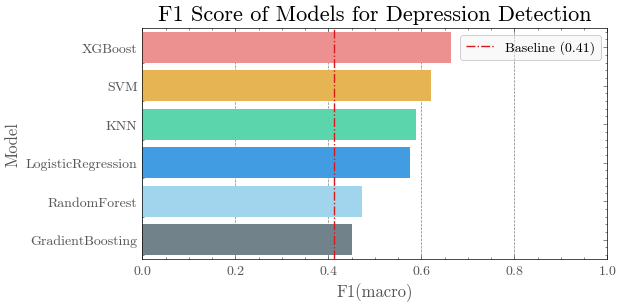

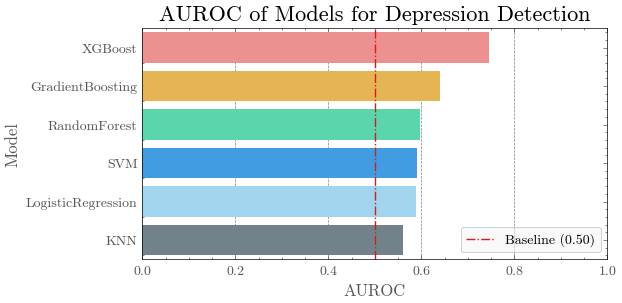

In [4]:
from src import plot_result
import os
os.makedirs("result/viz", exist_ok=True)

plot_result(result, metric='F1(macro)', sort=True, title="F1 Score of Models for Depression Detection", save_path="result/viz/feature_all_model_ml_metric_f1.png")
plot_result(result, metric='AUROC', sort=True, title="AUROC of Models for Depression Detection", save_path="result/viz/feature_all_model_ml_metric_auroc.png")

## Ablation Study
- Features: All, openSMILE, utterance
- feature selection: None, kbest, model

In [ ]:
# All features

# k-best top 50
display(pipeline.evaluate_models(
    use_feature_selection=True,
    selection_method='kbest',
    k_features=50,
    show_selected_features=True
))

# model-based with random forest
display(pipeline.evaluate_models(
    use_feature_selection=True,
    selection_method='model',
    show_selected_features=True
))

[Feature Selection: kbest] Selected 49 features:
['F0semitoneFrom27.5Hz_sma3nz_stddevNorm', 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0', 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2', 'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope', 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope', 'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope', 'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope', 'loudness_sma3_amean', 'loudness_sma3_stddevNorm', 'loudness_sma3_percentile20.0', 'loudness_sma3_percentile50.0', 'loudness_sma3_percentile80.0', 'loudness_sma3_pctlrange0-2', 'loudness_sma3_meanRisingSlope', 'loudness_sma3_stddevRisingSlope', 'loudness_sma3_meanFallingSlope', 'loudness_sma3_stddevFallingSlope', 'spectralFlux_sma3_amean', 'spectralFlux_sma3_stddevNorm', 'mfcc1_sma3_amean', 'mfcc1_sma3_stddevNorm', 'mfcc2_sma3_amean', 'mfcc2_sma3_stddevNorm', 'mfcc3_sma3_amean', 'mfcc3_sma3_stddevNorm', 'mfcc4_sma3_amean', 'mf

,Model,Accuracy,F1(macro),AUROC
0,SVM,0.617021,0.559375,0.547619
1,KNN,0.680851,0.461421,0.531385
2,RandomForest,0.702128,0.472756,0.601732
3,LogisticRegression,0.680851,0.591304,0.586580
4,GradientBoosting,0.680851,0.540117,0.653680
5,XGBoost,0.744681,0.618919,0.673160


[Feature Selection: model] Selected 46 features:
['F0semitoneFrom27.5Hz_sma3nz_amean', 'F0semitoneFrom27.5Hz_sma3nz_stddevNorm', 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0', 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2', 'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope', 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope', 'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope', 'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope', 'loudness_sma3_amean', 'loudness_sma3_stddevNorm', 'loudness_sma3_percentile20.0', 'loudness_sma3_percentile50.0', 'loudness_sma3_percentile80.0', 'loudness_sma3_pctlrange0-2', 'loudness_sma3_meanRisingSlope', 'loudness_sma3_stddevRisingSlope', 'loudness_sma3_meanFallingSlope', 'loudness_sma3_stddevFallingSlope', 'spectralFlux_sma3_amean', 'spectralFlux_sma3_stddevNorm', 'mfcc1_sma3_amean', 'mfcc1_sma3_stddevNorm', 'mfcc2_sma3_amean', 'mfcc2_sma3_stddevNorm', 'mfcc3_sma3_amean', 'mfcc3_sma3

,Model,Accuracy,F1(macro),AUROC
0,SVM,0.638298,0.576127,0.521645
1,KNN,0.702128,0.472756,0.701299
2,RandomForest,0.702128,0.472756,0.574675
3,LogisticRegression,0.680851,0.610282,0.567100
4,GradientBoosting,0.680851,0.505263,0.610390
5,XGBoost,0.765957,0.662753,0.688312


In [10]:
smile_pipeline = MLPipeline(df, feature_cols=smile_columns)

display(smile_pipeline.evaluate_models())

# k-best top 50
display(smile_pipeline.evaluate_models(
    use_feature_selection=True,
    selection_method='kbest',
    k_features=50,
    show_selected_features=True
))

# model-based with random forest
display(smile_pipeline.evaluate_models(
    use_feature_selection=True,
    selection_method='model',
    show_selected_features=True
))

,Model,Accuracy,F1(macro),AUROC
0,SVM,0.659574,0.631373,0.651515
1,KNN,0.680851,0.505263,0.489177
2,RandomForest,0.702128,0.472756,0.577922
3,LogisticRegression,0.702128,0.657292,0.608225
4,GradientBoosting,0.680851,0.540117,0.666667
5,XGBoost,0.723404,0.533231,0.610390


[Feature Selection: kbest] Selected 49 features:
['F0semitoneFrom27.5Hz_sma3nz_stddevNorm', 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0', 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2', 'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope', 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope', 'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope', 'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope', 'loudness_sma3_amean', 'loudness_sma3_stddevNorm', 'loudness_sma3_percentile20.0', 'loudness_sma3_percentile50.0', 'loudness_sma3_percentile80.0', 'loudness_sma3_pctlrange0-2', 'loudness_sma3_meanRisingSlope', 'loudness_sma3_stddevRisingSlope', 'loudness_sma3_meanFallingSlope', 'loudness_sma3_stddevFallingSlope', 'spectralFlux_sma3_amean', 'spectralFlux_sma3_stddevNorm', 'mfcc1_sma3_amean', 'mfcc1_sma3_stddevNorm', 'mfcc2_sma3_amean', 'mfcc2_sma3_stddevNorm', 'mfcc3_sma3_amean', 'mfcc3_sma3_stddevNorm', 'mfcc4_sma3_amean', 'mf

,Model,Accuracy,F1(macro),AUROC
0,SVM,0.574468,0.491342,0.443723
1,KNN,0.595745,0.373333,0.468615
2,RandomForest,0.702128,0.412500,0.606061
3,LogisticRegression,0.638298,0.536812,0.495671
4,GradientBoosting,0.744681,0.664286,0.582251
5,XGBoost,0.638298,0.536812,0.616883


[Feature Selection: model] Selected 35 features:
['F0semitoneFrom27.5Hz_sma3nz_stddevNorm', 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0', 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2', 'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope', 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope', 'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope', 'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope', 'loudness_sma3_amean', 'loudness_sma3_stddevNorm', 'loudness_sma3_percentile20.0', 'loudness_sma3_percentile50.0', 'loudness_sma3_percentile80.0', 'loudness_sma3_pctlrange0-2', 'loudness_sma3_meanRisingSlope', 'loudness_sma3_stddevRisingSlope', 'loudness_sma3_meanFallingSlope', 'loudness_sma3_stddevFallingSlope', 'spectralFlux_sma3_amean', 'spectralFlux_sma3_stddevNorm', 'mfcc1_sma3_amean', 'mfcc1_sma3_stddevNorm', 'mfcc2_sma3_amean', 'mfcc2_sma3_stddevNorm', 'mfcc3_sma3_amean', 'mfcc3_sma3_stddevNorm', 'mfcc4_sma3_amean', 'mf

,Model,Accuracy,F1(macro),AUROC
0,SVM,0.638298,0.478800,0.445887
1,KNN,0.659574,0.450292,0.480519
2,RandomForest,0.659574,0.397436,0.585498
3,LogisticRegression,0.617021,0.465909,0.428571
4,GradientBoosting,0.702128,0.555405,0.627706
5,XGBoost,0.680851,0.461421,0.601732


In [11]:
utt_pipeline = MLPipeline(df, feature_cols=utterance_columns)

# k-best top 50
display(utt_pipeline.evaluate_models())

# model-based with random forest
display(utt_pipeline.evaluate_models(
    use_feature_selection=True,
    selection_method='model',
    show_selected_features=True
))

,Model,Accuracy,F1(macro),AUROC
0,SVM,0.638298,0.510716,0.415584
1,KNN,0.595745,0.373333,0.456710
2,RandomForest,0.638298,0.439298,0.561688
3,LogisticRegression,0.617021,0.496429,0.647186
4,GradientBoosting,0.638298,0.510716,0.571429
5,XGBoost,0.680851,0.568279,0.614719


[Feature Selection: model] Selected 18 features:
['Num_Utterances_Ellie', 'Num_Utterances_Participant', 'Total_Duration_Ellie', 'Total_Duration_Participant', 'Avg_Utterance_Duration_Participant', 'Total_Interview_Duration', 'Total_Word_Count_Ellie', 'Total_Word_Count_Participant', 'Avg_Word_Count_Participant', 'Num_Turns', 'Total_Turns', 'Total_Silence_Duration', 'Avg_Silence_Duration', 'Max_Silence_Duration', 'Std_Silence_Duration', 'Silence_Duration_Ratio', 'Avg_Reaction_Time', 'Max_Reaction_Time']


,Model,Accuracy,F1(macro),AUROC
0,SVM,0.702128,0.412500,0.547619
1,KNN,0.574468,0.364865,0.387446
2,RandomForest,0.659574,0.450292,0.560606
3,LogisticRegression,0.617021,0.465909,0.545455
4,GradientBoosting,0.702128,0.555405,0.543290
5,XGBoost,0.659574,0.574661,0.504329
